In [303]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import json
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Визаулизация латентных векторов

Считываем матрицу с признаками

In [70]:
df = pd.read_csv("crypto_predictor/F.csv", header=None)
df = df.drop([10], axis = 1)
print(df.shape)
df.head()

(1212, 10)


,0,1,2,3,4,5,6,7,8,9
0,0.504022,-0.765992,0.519239,-1.007107,0.096403,-0.290291,-1.125191,-0.562446,1.441868,-0.561741
1,1.437266,-1.843437,0.662633,-1.008336,-0.746416,-0.259049,1.100097,0.303888,0.044787,0.594443
2,-0.373369,-1.162690,0.858063,-0.700640,-1.338919,-1.449326,0.557537,1.319527,0.097687,-0.284037
3,0.941469,2.514636,0.377614,-1.556576,0.605592,-0.806821,0.597518,0.045091,-0.505817,-0.321008
4,-0.180384,-0.191564,0.014465,0.852456,0.569239,1.646948,0.303593,-0.133763,-0.828306,-0.039923


In [73]:
1212 / 6

202.0

In [74]:
q = df.values.reshape(1, -1).reshape(202, 60)

In [75]:
km = KMeans()
km.fit(q)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [76]:
pca=PCA(n_components=2, whiten=True)
data2D = pca.fit_transform(q)

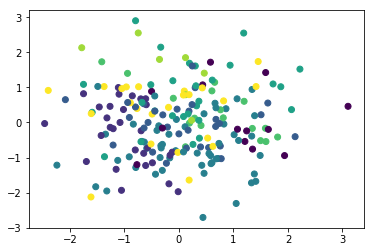

In [77]:
plt.scatter(data2D[:, 0], data2D[:, 1], c = km.labels_)
plt.show()

In [78]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(q)

In [79]:
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_scaled)

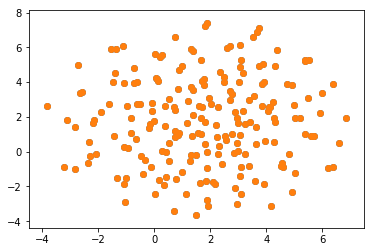

In [81]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1])
plt.show()

Каких-либо однозначных выводов нельзя сказать о кластеризации криптовалют. 

# Оценка качества прогноза

Для начала попробуем на некотором разминочном. На двух колонках. Подробный конфиг ниже

In [315]:
json.loads(open("crypto_predictor/configuration.json").read())

{'ARLags': 5,
 'frequency': 'hour',
 'lambda_F': 1.5,
 'lambda_w': 1.5,
 'lambda_x': 1.5,
 'latent_dimension': 10,
 'max_iterations': 10,
 'necessary_columns': [1, 2, 3],
 'number_input_files': 200,
 'percentage_using_data': 90}

In [232]:
algo_prediction = pd.read_csv('crypto_predictor/prediction.csv', header=None).T
print(algo_prediction.shape)
algo_prediction.head()

(31, 600)


,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.000151,0.000053,0.001052,0.001284,-0.000368,-0.000533,-0.000757,-0.000570,0.000861,0.000900,...,0.000597,0.001296,-0.000467,0.000447,-0.000095,-0.000743,-0.000170,0.000476,0.001052,0.001074
1,0.000121,0.000043,0.000857,0.001048,-0.000304,-0.000436,-0.000620,-0.000468,0.000700,0.000733,...,0.000486,0.001063,-0.000381,0.000361,-0.000077,-0.000607,-0.000140,0.000382,0.000860,0.000872
2,0.000090,0.000033,0.000661,0.000811,-0.000239,-0.000338,-0.000482,-0.000366,0.000538,0.000565,...,0.000374,0.000827,-0.000295,0.000273,-0.000059,-0.000471,-0.000111,0.000287,0.000667,0.000670
3,0.000061,0.000023,0.000463,0.000573,-0.000172,-0.000240,-0.000343,-0.000263,0.000377,0.000397,...,0.000262,0.000588,-0.000210,0.000188,-0.000041,-0.000333,-0.000082,0.000196,0.000473,0.000469
4,0.000032,0.000013,0.000265,0.000334,-0.000105,-0.000140,-0.000203,-0.000158,0.000215,0.000228,...,0.000150,0.000347,-0.000123,0.000103,-0.000023,-0.000193,-0.000052,0.000105,0.000277,0.000267


Функция для формирования матрицы предпрогнозных значений на основе исходных данных

In [236]:
def create_matrix():
    configuration = json.loads(open("crypto_predictor/configuration.json").read())
    df1 = pd.read_csv("data/BTC-1ST/hour/BTC-1ST_hour_1.csv", sep = ";", decimal = ",").set_index('TU')
    df1 = df1[df1.columns[configuration["necessary_columns"]]]
    
    frequency = configuration["frequency"]
    for folder in os.listdir("data")[1: configuration["number_input_files"]]:
        path = "data/" + folder + "/" + frequency + "/" + folder + "_" + frequency + "_1.csv"
        df2 = pd.read_csv(path, sep = ";", decimal = ",").set_index('TU')
        df2 = df2[df2.columns[configuration["necessary_columns"]]]
        df1 = pd.merge(df1, df2, left_index=True, right_index=True, how = "outer")
    return df1

In [264]:
train_timestamps = pd.read_csv("crypto_predictor/timestamps.csv").T
last_train_TS = float(train_timestamps.index[-2])
df = create_matrix()
df = df.reset_index()
df.head()

,TU,O_x,C_x,L_x,O_y,C_y,L_y,O_x,C_x,L_x,...,L_x,O_y,C_y,L_y,O_x,C_x,L_x,O_y,C_y,L_y
0,1.508522e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.508526e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.037446,0.037641,0.037327,NaN,NaN,NaN,NaN,NaN,NaN
2,1.508530e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.037327,0.036800,0.036800,NaN,NaN,NaN,NaN,NaN,NaN
3,1.508533e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.036800,0.036985,0.036800,NaN,NaN,NaN,NaN,NaN,NaN
4,1.508537e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.036988,0.036665,0.036087,NaN,NaN,NaN,NaN,NaN,NaN


In [271]:
traindf = df[df["TU"] <= last_train_TS]
testdf = df[df["TU"] > last_train_TS]
testdf = testdf.iloc[: 31]
testdf = testdf.drop('TU', axis = 1)
traindf = traindf.drop('TU', axis = 1)
print("test df shape", testdf.shape)
print("prediction df shape", algo_prediction.shape)

In [311]:
traindf.columns = np.arange(len(traindf.columns))
testdf.columns = np.arange(len(testdf.columns))
traindf.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.037446,0.037641,0.037327,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.037327,0.036800,0.036800,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.036800,0.036985,0.036800,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.036988,0.036665,0.036087,NaN,NaN,NaN,NaN,NaN,NaN


In [312]:
testdf.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
2415,0.000088,0.000089,0.000086,0.000001,0.000001,0.000001,0.000002,0.000002,0.000002,0.000053,...,0.012450,0.040300,0.039945,0.039937,0.004175,0.004095,0.004070,0.60800,0.601000,0.60001
2416,0.000089,0.000088,0.000088,0.000001,0.000001,0.000001,0.000002,0.000002,0.000002,0.000053,...,0.012980,0.039945,0.040202,0.039755,0.004095,0.004067,0.004067,0.60200,0.604300,0.60100
2417,0.000088,0.000087,0.000087,0.000001,0.000001,0.000001,0.000002,0.000002,0.000002,0.000053,...,0.012980,0.040202,0.040428,0.040023,0.004067,0.004020,0.003936,0.60430,0.597001,0.59200
2418,0.000087,0.000087,0.000087,0.000001,0.000001,0.000001,0.000002,0.000002,0.000002,0.000053,...,0.012652,0.040223,0.039900,0.039900,0.004020,0.003982,0.003838,0.59400,0.595010,0.58300
2419,0.000087,0.000085,0.000085,0.000001,0.000001,0.000001,0.000002,0.000002,0.000002,0.000053,...,0.012207,0.039900,0.039880,0.039816,0.003990,0.004026,0.003982,0.59501,0.601603,0.59100


In [313]:
algo_prediction.head()


,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.000151,0.000053,0.001052,0.001284,-0.000368,-0.000533,-0.000757,-0.000570,0.000861,0.000900,...,0.000597,0.001296,-0.000467,0.000447,-0.000095,-0.000743,-0.000170,0.000476,0.001052,0.001074
1,0.000121,0.000043,0.000857,0.001048,-0.000304,-0.000436,-0.000620,-0.000468,0.000700,0.000733,...,0.000486,0.001063,-0.000381,0.000361,-0.000077,-0.000607,-0.000140,0.000382,0.000860,0.000872
2,0.000090,0.000033,0.000661,0.000811,-0.000239,-0.000338,-0.000482,-0.000366,0.000538,0.000565,...,0.000374,0.000827,-0.000295,0.000273,-0.000059,-0.000471,-0.000111,0.000287,0.000667,0.000670
3,0.000061,0.000023,0.000463,0.000573,-0.000172,-0.000240,-0.000343,-0.000263,0.000377,0.000397,...,0.000262,0.000588,-0.000210,0.000188,-0.000041,-0.000333,-0.000082,0.000196,0.000473,0.000469
4,0.000032,0.000013,0.000265,0.000334,-0.000105,-0.000140,-0.000203,-0.000158,0.000215,0.000228,...,0.000150,0.000347,-0.000123,0.000103,-0.000023,-0.000193,-0.000052,0.000105,0.000277,0.000267


In [285]:
train_length = traindf[[3]].shape[0]
test_length = testdf[[3]].shape[0]

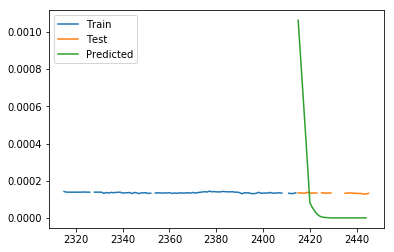

In [318]:
plt.plot(np.arange(train_length)[-100:], traindf[[74]][-100:], label = "Train")
plt.plot(np.arange(train_length, train_length + test_length), testdf[[74]], label = "Test")
plt.plot(np.arange(train_length, train_length + test_length), algo_prediction[[74]], label = "Predicted")
plt.legend()
plt.show()


In [316]:
r2_values = []
for i in range(600):
    r2_values.append(r2_score(np.nan_to_num(algo_prediction[[i]].values), np.nan_to_num(testdf[[i]].values)))
print(np.mean(r2_values))

-259303.368659


In [307]:
np.argmax(r2_values)

74

Увеличим нагрузку. Попробуем дневные интервалы, увеличим количество итераций и посмотрим, что из этого получится. 

In [347]:
train_timestamps = pd.read_csv("crypto_predictor/timestamps.csv").T
last_train_TS = float(train_timestamps.index[-2])
df = create_matrix()
df = df.reset_index()

df.head()

,TU,O_x,C_x,L_x,H_x,O_y,C_y,L_y,H_y,O_x,...,L_y,H_y,O_x,C_x,L_x,H_x,O_y,C_y,L_y,H_y
0,1.392336e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.392595e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.392682e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.392768e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.392854e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [348]:
algo_prediction = pd.read_csv('crypto_predictor/prediction.csv', header=None).T
traindf = df[df["TU"] <= last_train_TS]
testdf = df[df["TU"] > last_train_TS]
testdf = testdf.iloc[: 31]
testdf = testdf.drop('TU', axis = 1)
traindf = traindf.drop('TU', axis = 1)
print("test df shape", testdf.shape)
print("prediction df shape", algo_prediction.shape)
traindf.columns = np.arange(len(traindf.columns))
testdf.columns = np.arange(len(testdf.columns))

test df shape (31, 800)
prediction df shape (31, 800)


In [349]:
r2_values = []
for i in range(600):
    r2_values.append(r2_score(np.nan_to_num(algo_prediction[[i]].values), np.nan_to_num(testdf[[i]].values)))
print(np.mean(r2_values))

0.04


In [350]:
np.argmax(r2_values)

108

In [351]:
r2_values[108]

1.0